# Conexiones e importaciones

In [2]:
# --- 1. IMPORTACIÓN DE LIBRERÍAS Y SEGURIDAD ---

# --- PREPARACIÓN DEL ENTORNO ---
# Importamos las librerías necesarias para la conexión y el manejo de datos
import os #trabajar con el sistema operativo y variables de entorno
import pandas as pd #dataframes para manipular el CSV
import mysql.connector #conector oficial de MySQL para Python
import numpy as np #librería para manejo de valores nulos (NaN)
from dotenv import load_dotenv #cargar variables de entorno desde el archivo .env
import glob #manejo de archivos y rutas
import matplotlib.pyplot as plt # Para transformar datos en gráficos visuales

load_dotenv() # Carga las variables definidas en el archivo .env // Devuelve True si se cargan correctamente, False si no
host=os.getenv("MYSQL_HOST") # Obtiene el valor de la variable de entorno MYSQL_HOST
user=os.getenv("MYSQL_USER") # Obtiene el usuario de la base de datos
password=os.getenv("MYSQL_PASSWORD") # Obtiene la contraseña de la base de datos

In [3]:
# --- Cargamos las variables de entorno ---
load_dotenv()  # Busca automáticamente un archivo .env en la carpeta del script
# Ahora podemos usar os.getenv('NOMBRE_VARIABLE') para obtener valores seguros

# --- Intentamos conectarnos al servidor MySQL ---
try:
    # Creamos la conexión y la guardamos en la variable 'cnx'
    cnx = mysql.connector.connect(
        host=os.getenv('MYSQL_HOST'),                  # Dirección del servidor MySQL (localhost o IP)
        user=os.getenv('MYSQL_USER'),                  # Usuario que se conectará (ej. root)
        password=os.getenv('MYSQL_PASSWORD'),          # Contraseña del usuario
        port=int(os.getenv('MYSQL_PORT', 3306)),       # Puerto de MySQL (por defecto 3306)
        use_pure=True,                                 # Usa el conector puro de Python, más compatible
        auth_plugin='mysql_native_password',           # Forza usar el plugin antiguo compatible con clientes
        database='musicstream'
    )

    # Si llegamos aquí, la conexión fue exitosa
    print('Conexión exitosa')  # Mensaje de confirmación

# --- Capturamos cualquier error relacionado con MySQL ---
except mysql.connector.Error as e:
    # Si ocurre un error, lo imprimimos para diagnosticarlo
    print('Error al conectar:', e)

Conexión exitosa


In [4]:
# -------------------------------
# 🎯 CONSULTA 1: Top 10 artistas con más oyentes
# -------------------------------

# Creamos un cursor con "dictionary=True".
# -------------------------------
# Por qué usamos dictionary=True:
# - Normalmente, fetchall() devuelve una lista de tuplas:
#       [(artista1, listeners1), (artista2, listeners2), ...]
#   Esto es difícil de manejar si queremos acceder a los valores por nombre de columna.
# - Con dictionary=True, cada fila devuelta es un diccionario:
#       [{'Nombre_Artista': artista1, 'Listeners': listeners1}, ...]
#   Esto hace que sea más fácil y seguro convertir los resultados a un DataFrame
#   y trabajar con nombres de columna explícitos en pandas, evitando errores por orden de columnas.
# - Es especialmente útil cuando tenemos consultas complejas con muchas columnas,
#   joins o agregaciones, porque podemos acceder a los campos por su nombre, no por posición.
mycursor = cnx.cursor(dictionary=True)

# -------------------------------
# SQL: Seleccionamos los artistas con más oyentes
# -------------------------------
# Esta consulta tiene un objetivo doble:
# 1️⃣ Analítico: identificar los artistas con mayor alcance en la plataforma.
# 2️⃣ Estratégico de mercado: entender dónde se concentra la audiencia.
#
# Desglose de la consulta:
# - SELECT Nombre_Artista, Listeners: seleccionamos solo la información relevante.
# - FROM Artistas: trabajamos sobre la tabla principal de artistas.
# - ORDER BY Listeners DESC: ordenamos de mayor a menor para identificar los líderes de audiencia.
# - LIMIT 10: nos centramos en los top 10, que es suficiente para análisis de tendencia y benchmarking.
query1 = """
SELECT Nombre_Artista, Listeners
FROM Artistas
ORDER BY Listeners DESC
LIMIT 10;
"""

# -------------------------------
# Ejecutamos la consulta
# -------------------------------
# execute() envía la consulta a la base de datos.
# La base de datos procesa la consulta y prepara los resultados, pero no los devuelve directamente.
mycursor.execute(query1)

# -------------------------------
# fetchall(): traer todos los resultados
# -------------------------------
# - fetchall() obtiene todas las filas que produjo la consulta y las guarda en Python.
# - Si no usamos fetchall(), no tenemos acceso a los resultados.
# - Con dictionary=True, cada fila es un diccionario con nombres de columna.
#   Esto permite convertirlo directamente a un DataFrame de pandas con columnas bien definidas.
resultados = mycursor.fetchall()

# -------------------------------
# Convertimos los resultados a DataFrame
# -------------------------------
# - Los DataFrames son la estructura más poderosa de pandas para análisis de datos:
#   permiten filtrar, agrupar, ordenar y visualizar fácilmente.
# - Aquí convertimos cada diccionario (fila) en una fila del DataFrame.
import pandas as pd
df_top_10_artistas = pd.DataFrame(resultados)

# -------------------------------
# Anotaciones estratégicas de mercado
# -------------------------------
# 1️⃣ ¿Por qué nos interesa esta información?
# - Nos indica dónde se concentra la atención de los oyentes.
# - Permite identificar líderes de mercado y sus estrategias implícitas (géneros, estilos, colaboraciones).
# - Nos ayuda a comparar el potencial de nuevos artistas frente a los top 10.
#
# 2️⃣ Relevancia de los datos:
# - Listeners es un indicador de impacto directo: más oyentes significa mayor influencia y visibilidad.
# - Esta métrica combinada con otras consultas (ej. ratio demanda vs competencia) permite detectar oportunidades en géneros menos saturados.
#
# 3️⃣ Cómo pensar como analista:
# - No solo vemos quién tiene más oyentes, sino qué patrones podemos extraer:
#     * Géneros dominantes
#     * Posicionamiento estratégico de artistas
#     * Nichos de mercado donde un artista emergente puede crecer
#
# En otras palabras, esto no es solo un ranking, sino un **input para decisiones estratégicas**.

print("🎯 Top 10 artistas con más oyentes")
display(df_top_10_artistas)

# Cerramos el cursor para liberar recursos, la conexión cnx sigue abierta para otras consultas
mycursor.close()


🎯 Top 10 artistas con más oyentes


,Nombre_Artista,Listeners
0,Radiohead,8048259
1,Nirvana,7373477
2,Red Hot Chili Peppers,7104490
3,Queen,7085762
4,Arctic Monkeys,6924955
5,The Killers,6796750
6,Linkin Park,6768133
7,Maroon 5,6474404
8,Green Day,6437276
9,The Beatles,6372317


True

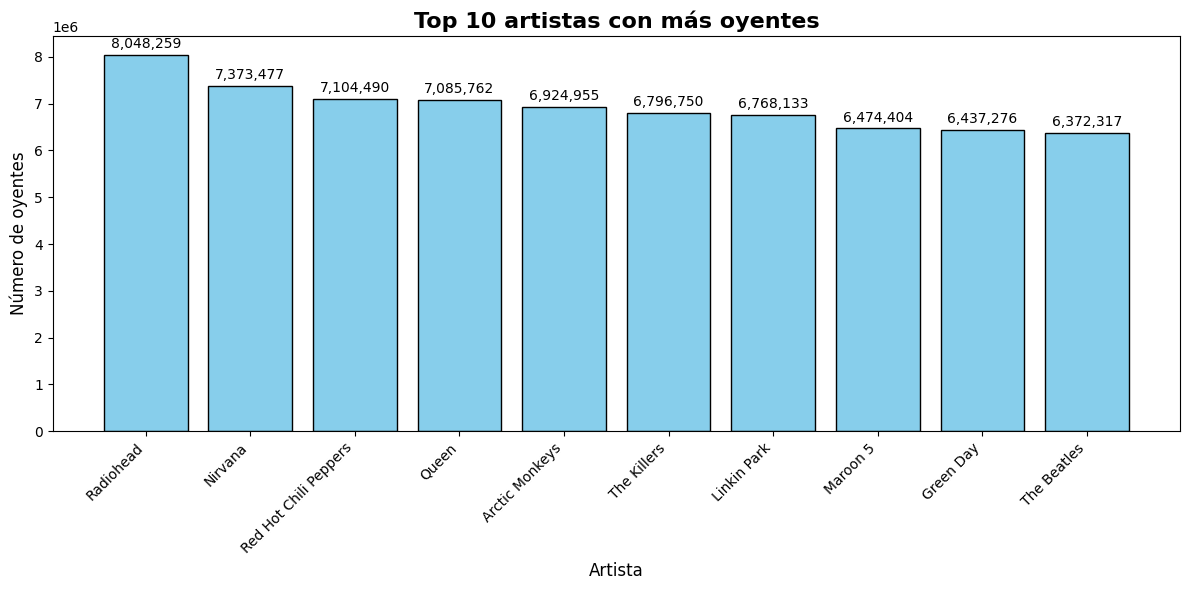

In [5]:
# -------------------------------
# GRÁFICO: Top 10 artistas con más oyentes
# -------------------------------

# Extraemos las columnas que necesitamos para el gráfico:
# - eje X: artistas
# - eje Y: número de oyentes
# Esto nos permite vincular visualmente cada artista con su audiencia.
artistas = df_top_10_artistas['Nombre_Artista']
oyentes = df_top_10_artistas['Listeners']

# -------------------------------
# Crear figura y definir tamaño
# -------------------------------
# plt.figure() crea un lienzo donde dibujaremos el gráfico.
# figsize=(12,6) significa que el gráfico tendrá:
# - 12 pulgadas de ancho
# - 6 pulgadas de alto
# Por qué es importante:
# - Si el gráfico es muy estrecho, las etiquetas de los artistas se amontonan y se vuelven ilegibles.
# - Si es demasiado bajo, las barras se ven aplastadas y los números encima no caben.
# - Elegimos 12x6 como un tamaño equilibrado para mostrar 10 artistas claramente.
plt.figure(figsize=(12,6))

# -------------------------------
# Crear gráfico de barras
# -------------------------------
# color='skyblue': color uniforme para que todas las barras sean fáciles de comparar.
# edgecolor='black': borde de las barras, ayuda a diferenciar visualmente cada barra.
# Guardamos las barras en la variable 'bars' para poder colocar los valores encima después.
bars = plt.bar(artistas, oyentes, color='skyblue', edgecolor='black')

# -------------------------------
# Añadir título y etiquetas
# -------------------------------
# Título y etiquetas ayudan a que cualquier persona entienda de qué trata el gráfico.
# - fontsize y fontweight se ajustan para que sea claro y profesional.
plt.title("Top 10 artistas con más oyentes", fontsize=16, fontweight='bold')
plt.xlabel("Artista", fontsize=12)
plt.ylabel("Número de oyentes", fontsize=12)

# -------------------------------
# Rotar etiquetas del eje X
# -------------------------------
# Problema: si los nombres de los artistas son largos y hay muchas barras, 
# las etiquetas se superponen y se vuelven ilegibles.
# Solución: rotar las etiquetas 45°.
# - Esto mantiene los nombres legibles sin ocupar demasiado espacio horizontal.
# - ha='right' alinea la etiqueta a la derecha, evitando que se solapen con la barra siguiente.
plt.xticks(rotation=45, ha='right')

# -------------------------------
# Mostrar valores sobre cada barra
# -------------------------------
# Añadir los números encima de cada barra ayuda a leer rápidamente los datos
# sin tener que mirar el eje Y.
# - bar.get_height() obtiene el valor de cada barra (oyentes)
# - Ajustamos la posición vertical sumando un pequeño porcentaje del máximo para que el número no choque con la barra
# - f'{int(altura):,}' muestra los números con separador de miles, más fácil de leer
for bar in bars:
    altura = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # centramos el texto horizontalmente sobre la barra
        altura + 0.01*max(oyentes),      # colocamos el texto un poco arriba de la barra
        f'{int(altura):,}',              # texto del número de oyentes
        ha='center', va='bottom', fontsize=10
    )

# -------------------------------
# Ajuste de layout
# -------------------------------
# plt.tight_layout() ajusta automáticamente los márgenes del gráfico
# Esto evita que el título, las etiquetas o los números se corten al mostrarlo
plt.tight_layout()

# -------------------------------
# Mostrar el gráfico
# -------------------------------
plt.show()


In [6]:
# -------------------------------
# 🎯 CONSULTA 2: Total de canciones por año
# -------------------------------

# Creamos un cursor con "dictionary=True"
# -------------------------------
# Por qué usamos dictionary=True:
# - Normalmente, fetchall() devuelve una lista de tuplas:
#       [(2020, 150), (2021, 180), ...]
#   Esto puede ser confuso si queremos acceder a los valores por nombre de columna.
# - Con dictionary=True, cada fila devuelta es un diccionario:
#       [{'año': 2020, 'total_canciones': 150}, ...]
#   Esto facilita convertir los resultados a un DataFrame y trabajar con nombres de columna explícitos.
# - Es especialmente útil si luego queremos combinar este DataFrame con otros o hacer gráficos.
mycursor = cnx.cursor(dictionary=True)

# -------------------------------
# SQL: contar canciones por año de lanzamiento
# -------------------------------
# Objetivo doble:
# 1️⃣ Analítico: identificar los años con mayor actividad musical
# 2️⃣ Estratégico de mercado: detectar tendencias, periodos de saturación o crecimiento
#
# Desglose de la consulta:
# - SELECT Anio AS año: renombramos la columna para mayor claridad
# - COUNT(*) AS total_canciones: contamos todas las canciones de cada año
# - FROM Canciones: tabla principal de canciones
# - GROUP BY Anio: agregamos por año
# - ORDER BY total_canciones DESC: listamos primero los años con más canciones
query2 = """
SELECT Anio AS año,
       COUNT(*) AS total_canciones
FROM Canciones
GROUP BY Anio
ORDER BY total_canciones DESC;
"""

# -------------------------------
# Ejecutamos la consulta
# -------------------------------
# execute() envía la consulta a la base de datos
mycursor.execute(query2)

# -------------------------------
# fetchall(): traer todos los resultados
# -------------------------------
# - fetchall() obtiene todas las filas que produjo la consulta y las guarda en Python
# - Cada fila es un diccionario con keys 'año' y 'total_canciones'
# - Esto permite convertirlo directamente a un DataFrame de pandas con columnas bien definidas
resultados = mycursor.fetchall()

# -------------------------------
# Convertimos los resultados a DataFrame
# -------------------------------
# - Los DataFrames permiten filtrar, ordenar, agrupar y graficar fácilmente
# - Cada diccionario se convierte en una fila del DataFrame
df_años_canciones = pd.DataFrame(resultados)

# -------------------------------
# Anotaciones estratégicas de mercado
# -------------------------------
# 1️⃣ ¿Por qué nos interesa esta información?
# - Nos indica qué años fueron más activos en la publicación de canciones
# - Permite detectar tendencias de crecimiento o saturación en la industria musical
# - Ayuda a planificar estrategias de lanzamiento para nuevos artistas según patrones históricos
#
# 2️⃣ Relevancia de los datos:
# - Años con más canciones pueden reflejar picos creativos, mayor inversión de sellos, o crecimiento de plataformas digitales
# - Combinado con métricas de oyentes, podemos identificar oportunidades donde la competencia es menor pero hay demanda
#
# 3️⃣ Cómo pensar como analista:
# - No solo vemos el año con más canciones, sino que extraemos patrones:
#     * Periodos de auge creativo
#     * Posibles correlaciones con tendencias de género
#     * Nichos de mercado menos saturados para artistas emergentes
#
# En otras palabras, esto no es solo un conteo de canciones, sino un **input para decisiones estratégicas**.

print("🎯 Total de canciones por año (ordenado por cantidad)")
display(df_años_canciones)

# Cerramos el cursor para liberar recursos; la conexión cnx sigue abierta para otras consultas
mycursor.close()


🎯 Total de canciones por año (ordenado por cantidad)


,año,total_canciones
0,2012,13811
1,2014,13230
2,2010,11039
3,2016,9264


True

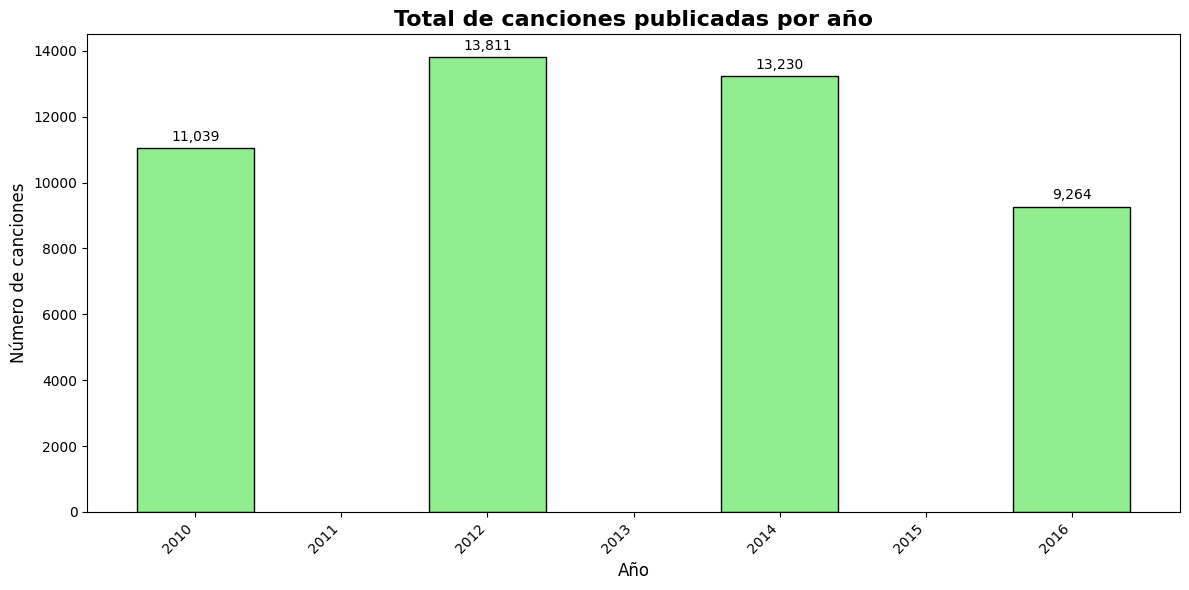

In [ ]:
# -------------------------------
# GRÁFICO: Total de canciones por año
# -------------------------------

# Extraemos las columnas que necesitamos para el gráfico:
# - eje X: años
# - eje Y: total de canciones
años = df_años_canciones['año']
total_canciones = df_años_canciones['total_canciones']

# -------------------------------
# Crear figura y definir tamaño
# -------------------------------
plt.figure(figsize=(12,6))

# -------------------------------
# Crear gráfico de barras
# -------------------------------
# color='lightgreen': color uniforme para facilitar comparación
# edgecolor='black': ayuda a diferenciar visualmente cada barra
bars = plt.bar(años, total_canciones, color='lightgreen', edgecolor='black')

# -------------------------------
# Añadir título y etiquetas
# -------------------------------
plt.title("Total de canciones publicadas por año", fontsize=16, fontweight='bold')
plt.xlabel("Año", fontsize=12)
plt.ylabel("Número de canciones", fontsize=12)

# -------------------------------
# Rotar etiquetas del eje X si es necesario
# -------------------------------
# - Si hay muchos años o etiquetas largas, se pueden rotar 45°
plt.xticks(rotation=45, ha='right')

# -------------------------------
# Mostrar valores sobre cada barra
# -------------------------------
for bar in bars:
    altura = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # centramos el texto horizontalmente
        altura + 0.01*max(total_canciones),  # pequeño margen sobre la barra
        f'{int(altura):,}',  # separador de miles
        ha='center', va='bottom', fontsize=10
    )

# -------------------------------
# Ajuste de layout
# -------------------------------
plt.tight_layout()

# -------------------------------
# Mostrar el gráfico
# -------------------------------
plt.show()


In [23]:
# ------------------------------- 
# 🎯 CONSULTA 3: Total de álbumes por año
# -------------------------------

# Creamos un cursor con "dictionary=True"
# -------------------------------
# Por qué usamos dictionary=True:
# - Normalmente, fetchall() devuelve una lista de tuplas:
#       [(2020, 15), (2021, 18), ...]
#   Esto puede ser confuso si queremos acceder a los valores por nombre de columna.
# - Con dictionary=True, cada fila devuelta es un diccionario:
#       [{'año': 2020, 'total_albumes': 15}, ...]
#   Esto facilita convertir los resultados a un DataFrame y trabajar con nombres de columna explícitos.
# - Es especialmente útil si luego queremos combinar este DataFrame con otros o hacer gráficos.
mycursor = cnx.cursor(dictionary=True)

# -------------------------------
# SQL: contar álbumes distintos por año de lanzamiento
# -------------------------------
# Objetivo doble:
# 1️⃣ Analítico: identificar los años con mayor producción de álbumes
# 2️⃣ Estratégico de mercado: detectar tendencias, periodos de saturación o crecimiento
#
# Desglose de la consulta:
# - SELECT Anio AS año: renombramos la columna para mayor claridad
# - COUNT(DISTINCT Album) AS total_albumes: contamos todos los álbumes distintos por año
# - FROM canciones: tabla principal donde están registradas las canciones
# - GROUP BY Anio: agregamos por año
# - ORDER BY Anio ASC: ordenamos cronológicamente de menor a mayor año
query3 = """
SELECT Anio AS año,
       COUNT(DISTINCT Album) AS total_albumes
FROM canciones
GROUP BY Anio
ORDER BY Anio ASC;
"""

# -------------------------------
# Ejecutamos la consulta
# -------------------------------
mycursor.execute(query3)

# -------------------------------
# fetchall(): traer todos los resultados
# -------------------------------
# - fetchall() obtiene todas las filas que produjo la consulta y las guarda en Python
# - Cada fila es un diccionario con keys 'año' y 'total_albumes'
# - Esto permite convertirlo directamente a un DataFrame de pandas con columnas bien definidas
resultados = mycursor.fetchall()

# -------------------------------
# Convertimos los resultados a DataFrame
# -------------------------------
# - Los DataFrames permiten filtrar, ordenar, agrupar y graficar fácilmente
# - Cada diccionario se convierte en una fila del DataFrame
import pandas as pd
df_albumes_por_anyo = pd.DataFrame(resultados)

# -------------------------------
# Anotaciones estratégicas de mercado
# -------------------------------
# 1️⃣ ¿Por qué nos interesa esta información?
# - Nos indica qué años fueron más activos en la publicación de álbumes
# - Permite detectar tendencias de crecimiento o saturación en la industria musical
# - Ayuda a planificar estrategias de lanzamiento para nuevos artistas según patrones históricos
#
# 2️⃣ Relevancia de los datos:
# - Años con más álbumes pueden reflejar picos creativos, mayor inversión de sellos, o crecimiento de plataformas digitales
# - Combinado con métricas de oyentes, podemos identificar oportunidades donde la competencia es menor pero hay demanda
#
# 3️⃣ Cómo pensar como analista:
# - No solo vemos el año con más álbumes, sino que extraemos patrones:
#     * Periodos de auge creativo
#     * Posibles correlaciones con tendencias de género
#     * Nichos de mercado menos saturados para artistas emergentes
#
# En otras palabras, esto no es solo un conteo de álbumes, sino un **input para decisiones estratégicas**.

print("🎯 Total de álbumes por año")
display(df_albumes_por_anyo)

# Cerramos el cursor para liberar recursos; la conexión cnx sigue abierta para otras consultas
mycursor.close()

🎯 Total de álbumes por año


,año,total_albumes
0,2010,893
1,2012,1100
2,2014,1232
3,2016,1133


True

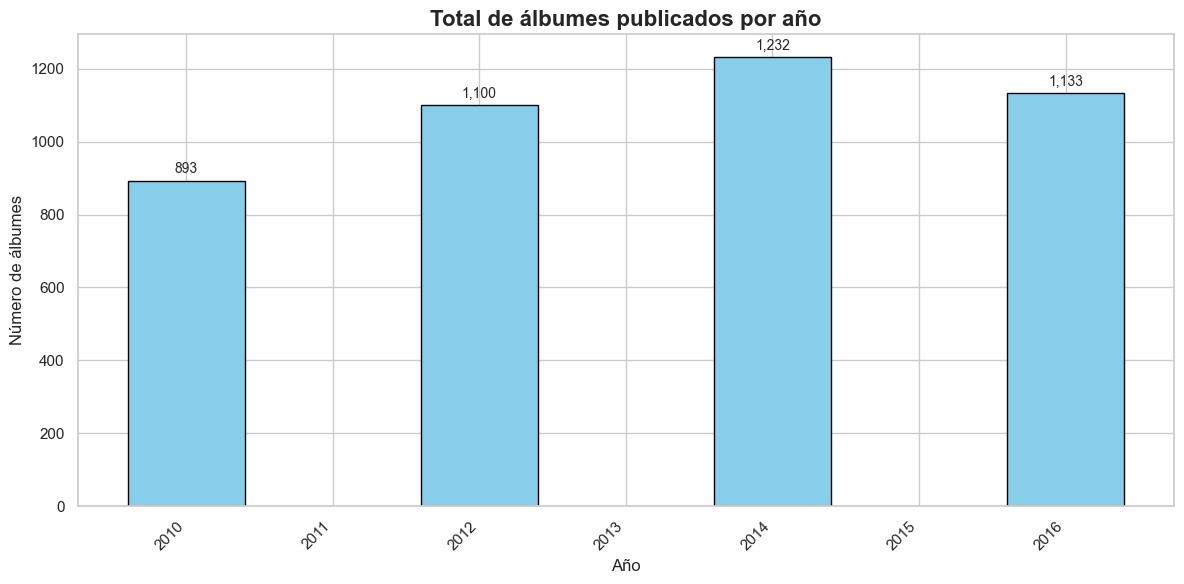

In [ ]:
# -------------------------------
# GRÁFICO: Total de álbumes por año
# -------------------------------

# Extraemos las columnas que necesitamos para el gráfico:
# - eje X: años
# - eje Y: total de álbumes
años = df_albumes_por_anyo['año']
total_albumes = df_albumes_por_anyo['total_albumes']

# -------------------------------
# Crear figura y definir tamaño
# -------------------------------
plt.figure(figsize=(12,6))

# -------------------------------
# Crear gráfico de barras
# -------------------------------
# color='skyblue': color uniforme para facilitar comparación
# edgecolor='black': ayuda a diferenciar visualmente cada barra
bars = plt.bar(años, total_albumes, color='skyblue', edgecolor='black')

# -------------------------------
# Añadir título y etiquetas
# -------------------------------
plt.title("Total de álbumes publicados por año", fontsize=16, fontweight='bold')
plt.xlabel("Año", fontsize=12)
plt.ylabel("Número de álbumes", fontsize=12)

# -------------------------------
# Rotar etiquetas del eje X si es necesario
# -------------------------------
plt.xticks(rotation=45, ha='right')

# -------------------------------
# Mostrar valores sobre cada barra
# -------------------------------
for bar in bars:
    altura = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # centramos el texto horizontalmente
        altura + 0.01*max(total_albumes),  # pequeño margen sobre la barra
        f'{int(altura):,}',  # separador de miles
        ha='center', va='bottom', fontsize=10
    )

# -------------------------------
# Ajuste de layout y mostrar gráfico
# -------------------------------
plt.tight_layout()
plt.show()

In [27]:
# ------------------------------- 
# 🎯 CONSULTA 4: Evolución de géneros por año
# -------------------------------

# Creamos un cursor con "dictionary=True"
# -------------------------------
# Por qué usamos dictionary=True:
# - Cada fila devuelta es un diccionario con nombres de columna,
#   lo que facilita acceder a los datos por nombre en lugar de por índice.
# - Ideal para convertir directamente a un DataFrame y trabajar con nombres claros.
mycursor = cnx.cursor(dictionary=True)

# -------------------------------
# SQL: contar canciones por género y año
# -------------------------------
# Objetivo:
# 1️⃣ Analítico: identificar qué géneros dominaron cada año y cómo evolucionaron
# 2️⃣ Estratégico de mercado: detectar tendencias, oportunidades para nuevos lanzamientos y campañas
#
# Desglose de la consulta:
# - SELECT Anio AS año: renombramos la columna para mayor claridad
# - Genero AS genero: incluimos el género para segmentar los resultados
# - COUNT(*) AS total_canciones: contamos todas las canciones por año y género
# - FROM Canciones: tabla principal donde se registran las canciones
# - GROUP BY Anio, Genero: agregamos por año y género
# - ORDER BY año, total_canciones DESC: orden cronológico por año, y dentro de cada año, géneros con más canciones primero
query4 = """
SELECT Anio AS año,
       Genero AS genero,
       COUNT(*) AS total_canciones
FROM Canciones
GROUP BY Anio, Genero
ORDER BY año, total_canciones DESC;
"""

# -------------------------------
# Ejecutamos la consulta
# -------------------------------
mycursor.execute(query4)

# -------------------------------
# Traemos todos los resultados
# -------------------------------
# - Cada fila es un diccionario con keys: 'año', 'genero', 'total_canciones'
# - Esto permite convertirlo directamente a un DataFrame
resultados = mycursor.fetchall()

# -------------------------------
# Convertimos a DataFrame
# -------------------------------
import pandas as pd
df_generos_año = pd.DataFrame(resultados)

# -------------------------------
# Análisis estratégico
# -------------------------------
# 1️⃣ Permite ver la evolución de los géneros a lo largo del tiempo
# 2️⃣ Útil para detectar géneros emergentes o en declive
# 3️⃣ Facilita la planificación de lanzamientos, marketing y decisiones editoriales
# 4️⃣ Combinado con métricas de oyentes o ventas, ayuda a identificar oportunidades de mercado
print("🎯 Evolución de géneros por año (canciones por género)")
display(df_generos_año)

# -------------------------------
# Cerramos el cursor para liberar recursos
# -------------------------------
mycursor.close()


🎯 Evolución de géneros por año (canciones por género)


,año,genero,total_canciones
0,2010,rock,4412
1,2010,jazz,2808
2,2010,country,2291
3,2010,latin,1528
4,2012,jazz,4616
5,2012,rock,4024
6,2012,country,2782
7,2012,latin,2389
8,2014,jazz,5020
9,2014,rock,3825


True

C:\Users\USER\AppData\Local\Temp\ipykernel_16620\2730647700.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', len(generos))


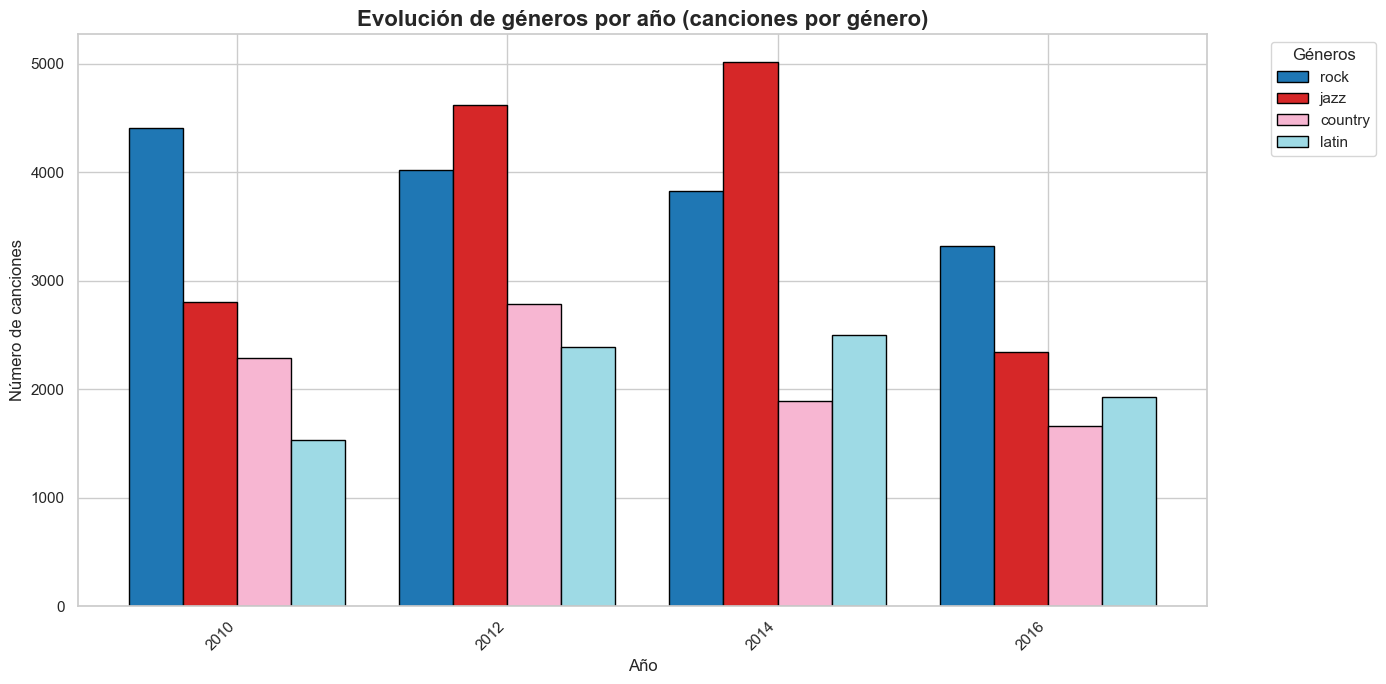

In [ ]:
# ------------------------------- 
# GRÁFICO: Evolución de géneros por año
# -------------------------------

# Queremos mostrar cómo evolucionaron los géneros en cada año.
# - eje X: años únicos (ordenados)
# - eje Y: número de canciones
# - cada género tendrá un color distinto
años = sorted(df_generos_año['año'].unique())
generos = df_generos_año['genero'].unique()

# -------------------------------
# Crear diccionario de colores para cada género
# -------------------------------
# Usamos la paleta 'tab20' que tiene 20 colores distintos
# Esto asegura que cada género tenga un color consistente en todo el gráfico
colormap = cm.get_cmap('tab20', len(generos))
color_dict = {genero: colormap(i) for i, genero in enumerate(generos)}

# -------------------------------
# Crear figura y definir tamaño
# -------------------------------
# figsize=(14,7) significa:
# - 14 pulgadas de ancho
# - 7 pulgadas de alto
# Esto da espacio suficiente para visualizar todos los años y géneros claramente
plt.figure(figsize=(14,7))

# -------------------------------
# Posición de las barras
# -------------------------------
# - x: posiciones numéricas para cada año
# - width: ancho de cada barra para que quepan los géneros dentro de cada año
x = np.arange(len(años))
width = 0.8 / len(generos)  # ajustamos ancho según número de géneros

# -------------------------------
# Dibujar las barras
# -------------------------------
# Iteramos sobre cada género y colocamos su barra correspondiente en cada año
for i, genero in enumerate(generos):
    valores = []
    for año in años:
        # Buscamos el total de canciones para este año y género
        fila = df_generos_año[(df_generos_año['año']==año) & (df_generos_año['genero']==genero)]
        if not fila.empty:
            valores.append(int(fila['total_canciones'].values[0]))
        else:
            valores.append(0)  # Si no hay canciones, ponemos 0
    # Dibujar barra
    # - x + i*width: desplazamos según el género
    # - color: color asignado al género
    # - edgecolor='black': bordes de las barras para diferenciarlas visualmente
    # - label: nombre del género, se usa para la leyenda
    plt.bar(x + i*width, valores, width=width, color=color_dict[genero], edgecolor='black', label=genero)

# -------------------------------
# Añadir título y etiquetas
# -------------------------------
# - Título explica de qué trata el gráfico
# - fontsize y fontweight hacen el título legible y profesional
plt.title("Evolución de géneros por año (canciones por género)", fontsize=16, fontweight='bold')
plt.xlabel("Año", fontsize=12)
plt.ylabel("Número de canciones", fontsize=12)

# -------------------------------
# Ajuste de etiquetas del eje X
# -------------------------------
# - Colocamos los ticks centrados en cada grupo de barras
# - Rotamos 45° para evitar superposición si hay muchos años
plt.xticks(x + width*(len(generos)-1)/2, años, rotation=45, ha='right')

# -------------------------------
# Añadir leyenda
# -------------------------------
# - Muestra qué color corresponde a cada género
# - bbox_to_anchor y loc colocan la leyenda fuera de la figura para que no tape las barras
plt.legend(title="Géneros", bbox_to_anchor=(1.05, 1), loc='upper left')

# -------------------------------
# Ajuste de layout
# -------------------------------
# - tight_layout() ajusta márgenes automáticamente para que nada se corte
plt.tight_layout()

# -------------------------------
# Mostrar el gráfico
# -------------------------------
plt.show()


In [38]:
# ------------------------------- 
# 🎯 CONSULTA 5: Artistas emergentes y crecimiento de oyentes
# -------------------------------

# Creamos un cursor con dictionary=True
# - Permite acceder a los resultados por nombre de columna
# - Facilita la conversión directa a DataFrame de pandas
mycursor = cnx.cursor(dictionary=True)

# -------------------------------
# SQL: artistas vinculados a sus canciones mediante clave foránea
# -------------------------------
# Objetivo:
# 1️⃣ Detectar artistas recientes y emergentes según su primer año de lanzamiento
# 2️⃣ Medir su popularidad actual (oyentes)
# 3️⃣ Evaluar productividad: número de álbumes y canciones publicadas
# 4️⃣ Identificar oportunidades de mercado y posibles tendencias de géneros
query5 = """
SELECT a.Nombre_Artista,
       MIN(c.Anio) AS primer_año,              -- primer año que publicó una canción
       a.Listeners AS oyentes_actuales,        -- audiencia actual
       COUNT(DISTINCT c.Album) AS total_albumes,  -- cantidad de álbumes publicados
       COUNT(c.Titulo) AS total_canciones         -- cantidad total de canciones
FROM Artistas a
JOIN Canciones c 
  ON a.Nombre_Artista = c.Artista_Relacion
GROUP BY a.Nombre_Artista, a.Listeners
ORDER BY primer_año ASC, oyentes_actuales DESC
LIMIT 10;
"""

# -------------------------------
# Ejecutamos la consulta
# - Enviamos la consulta a la base de datos
mycursor.execute(query5)

# -------------------------------
# Traemos todos los resultados
# - Cada fila es un diccionario con keys:
#   'Nombre_Artista', 'primer_año', 'oyentes_actuales', 'total_albumes', 'total_canciones'
resultados = mycursor.fetchall()

# -------------------------------
# Convertimos los resultados a DataFrame
# - Facilita filtrar, ordenar, agrupar y graficar
import pandas as pd
df_artistas_emergentes = pd.DataFrame(resultados)

# -------------------------------
# Análisis estratégico
# - Identifica artistas emergentes con potencial de crecimiento de audiencia
# - Combinando oyentes y productividad podemos priorizar inversión, promoción o scouting
# - Útil para planificar estrategias de marketing, lanzamiento de álbumes o descubrimiento de tendencias
print("🎯 Top 10 artistas emergentes según primer año de publicación y audiencia")
display(df_artistas_emergentes)

# -------------------------------
# Cerramos el cursor para liberar recursos
mycursor.close()


🎯 Top 10 artistas emergentes según primer año de publicación y audiencia


,Nombre_Artista,primer_año,oyentes_actuales,total_albumes,total_canciones
0,Radiohead,2010,8048259,9,22
1,Nirvana,2010,7373477,28,202
2,Queen,2010,7085762,194,1928
3,Arctic Monkeys,2010,6924955,3,8
4,The Killers,2010,6796750,66,388
5,Linkin Park,2010,6768133,20,167
6,Maroon 5,2010,6474404,14,126
7,Green Day,2010,6437276,40,374
8,The Beatles,2010,6372317,165,1863
9,Muse,2010,6250988,185,1582


True

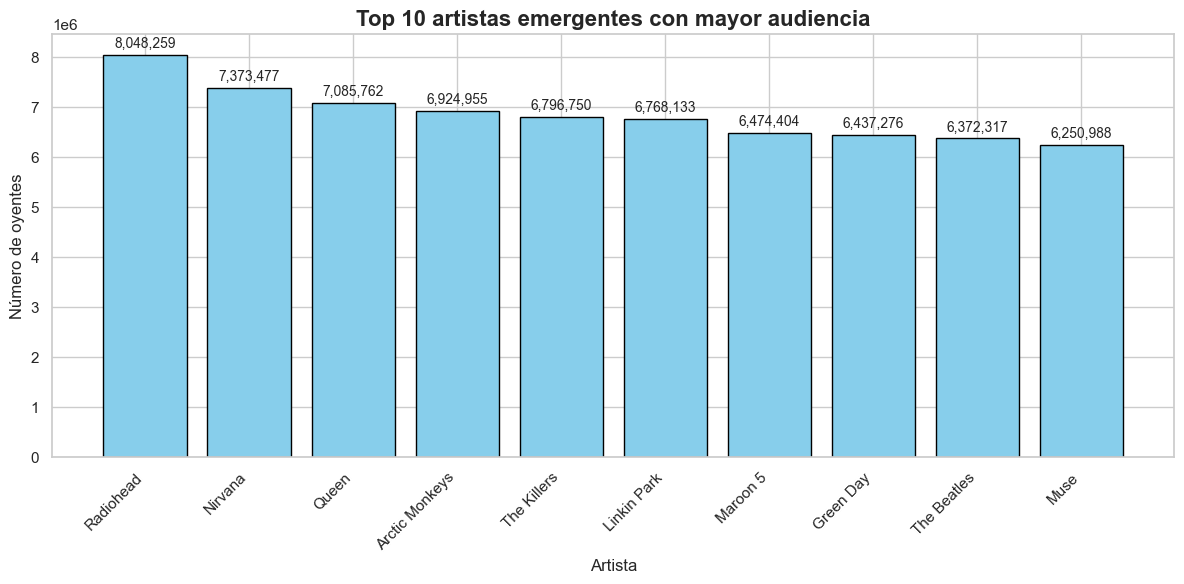

In [ ]:
# ------------------------------- 
# GRÁFICO: Top 10 artistas emergentes
# -------------------------------

# -------------------------------
# Extraemos los datos para el gráfico
# - eje X: nombres de los artistas
# - eje Y: número de oyentes (audiencia actual)
# Esto nos permite vincular visualmente cada artista con su popularidad
artistas = df_artistas_emergentes['Nombre_Artista']
oyentes = df_artistas_emergentes['oyentes_actuales']

# -------------------------------
# Crear figura y definir tamaño
# - figsize=(12,6) asegura que las barras y etiquetas sean legibles
# - Si el gráfico es muy estrecho, las etiquetas se amontonan y se vuelven ilegibles
# - Si es demasiado bajo, las barras se ven aplastadas y los números no caben
plt.figure(figsize=(12,6))

# -------------------------------
# Crear gráfico de barras
# - color='skyblue': color uniforme para facilitar comparación
# - edgecolor='black': ayuda a diferenciar visualmente cada barra
# - Guardamos las barras en 'bars' para colocar los valores encima
bars = plt.bar(artistas, oyentes, color='skyblue', edgecolor='black')

# -------------------------------
# Añadir título y etiquetas de ejes
# - Título y etiquetas claras para que cualquiera entienda de qué trata el gráfico
# - fontsize y fontweight ajustan la claridad y profesionalismo
plt.title("Top 10 artistas emergentes con mayor audiencia", fontsize=16, fontweight='bold')
plt.xlabel("Artista", fontsize=12)
plt.ylabel("Número de oyentes", fontsize=12)

# -------------------------------
# Rotar etiquetas del eje X
# - Problema: nombres largos o muchas barras superponen las etiquetas
# - Solución: rotar 45° y alinear a la derecha para legibilidad
plt.xticks(rotation=45, ha='right')

# -------------------------------
# Mostrar valores sobre cada barra
# - Ayuda a leer rápidamente los datos sin mirar el eje Y
# - bar.get_height() obtiene el valor de cada barra
# - Ajustamos la posición vertical sumando un pequeño porcentaje del máximo para que no choque con la barra
# - f'{int(altura):,}' agrega separador de miles para mejor lectura
for bar in bars:
    altura = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # centramos horizontalmente sobre la barra
        altura + 0.01*max(oyentes),      # colocamos el texto ligeramente arriba de la barra
        f'{int(altura):,}',              # formato con separador de miles
        ha='center', va='bottom', fontsize=10
    )

# -------------------------------
# Ajuste de layout
# - plt.tight_layout() ajusta automáticamente los márgenes
# - Evita que el título, etiquetas o números se corten al mostrar el gráfico
plt.tight_layout()

# -------------------------------
# Mostrar el gráfico
plt.show()
